In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\rattunet\drive


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/drive"
print(os.listdir(data_dir))

['training.zip', 'test', 'test.zip', 'training']


In [5]:
train_dir = data_dir + "/training"
test_dir = data_dir + "/test"

train_img_dir = train_dir + "/images"
train_mask_dir = train_dir + "/1st_manual"

test_img_dir = test_dir + "/images"

print(f"No. Train Img: {len(os.listdir(train_img_dir))}")
print(f"No. Train Msk: {len(os.listdir(train_mask_dir))}")
print(f"No. Test Img: {len(os.listdir(test_img_dir))}")

No. Train Img: 20
No. Train Msk: 20
No. Test Img: 20


In [6]:
class DriveDS(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(train_img_dir + "/*"))
        self.msks = sorted(glob(train_mask_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

20


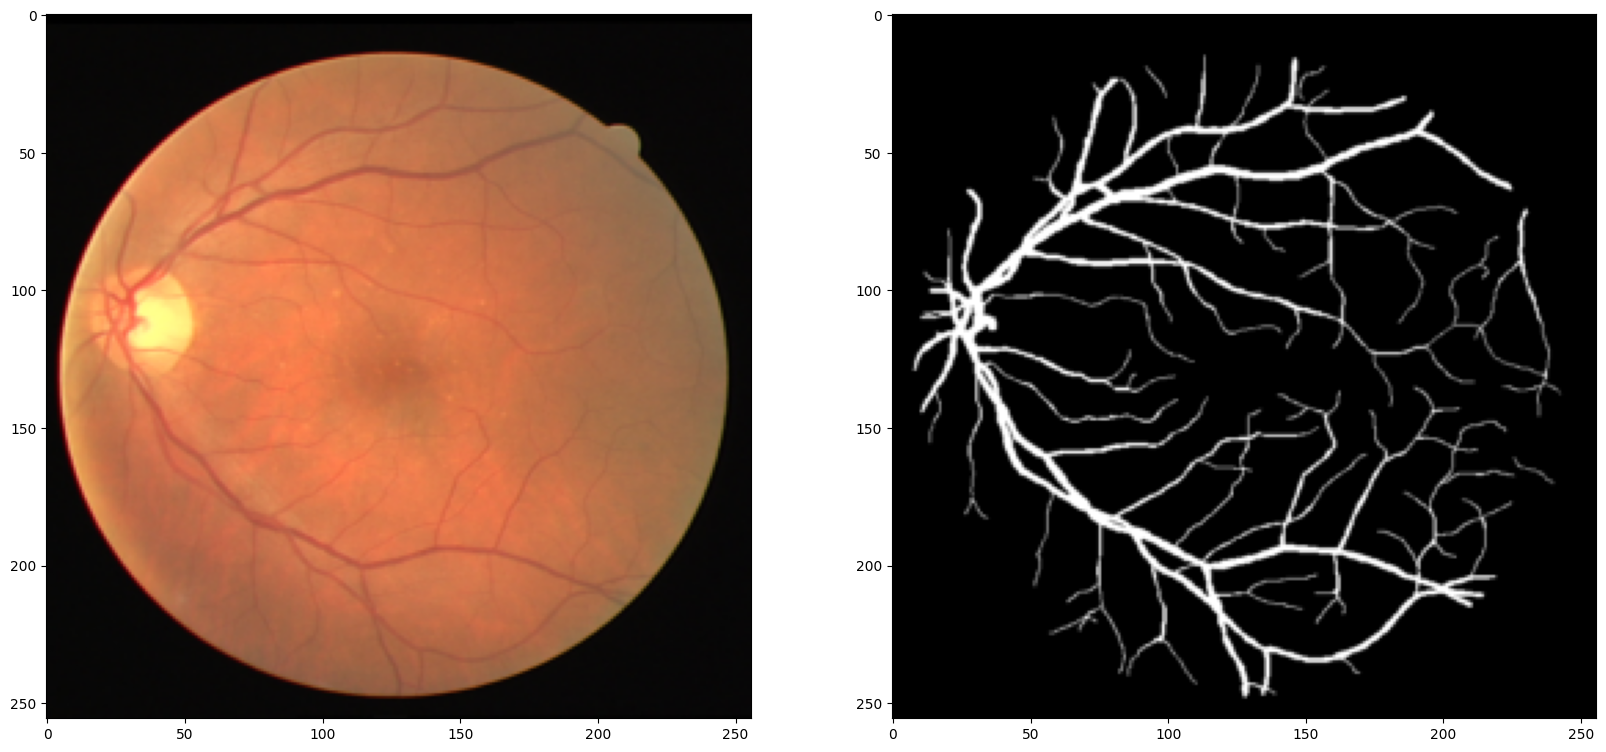

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

target_transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]
)

train_ds = DriveDS(transform = transform, target_transform=target_transform)

print(len(train_ds))

img, msk = train_ds[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [8]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

1


In [9]:
class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

In [10]:
class Recurrent_block(nn.Module):
    def __init__(self, out_ch, t=2):
        super(Recurrent_block, self).__init__()

        self.t = t
        self.out_ch = out_ch
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        out = 0
        for i in range(self.t):
            if i == 0:
                x = self.conv(x)
            out = self.conv(x + x)
        return out


class RRCNN_block(nn.Module):
    def __init__(self, in_ch, out_ch, t=2):
        super(RRCNN_block, self).__init__()

        self.RCNN = nn.Sequential(
            Recurrent_block(out_ch, t=t),
            Recurrent_block(out_ch, t=t)
        )
        self.Conv = nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x1 = self.Conv(x)
        x2 = self.RCNN(x1)
        out = x1 + x2
        return out

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

In [11]:
class R2AttU_Net(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, t=2, init_channels = 16):
        super(R2AttU_Net, self).__init__()

        n1 = init_channels
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.RRCNN1 = RRCNN_block(in_ch, filters[0], t=t)
        self.RRCNN2 = RRCNN_block(filters[0], filters[1], t=t)
        self.RRCNN3 = RRCNN_block(filters[1], filters[2], t=t)
        self.RRCNN4 = RRCNN_block(filters[2], filters[3], t=t)
        self.RRCNN5 = RRCNN_block(filters[3], filters[4], t=t)

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_RRCNN5 = RRCNN_block(filters[4], filters[3], t=t)

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_RRCNN4 = RRCNN_block(filters[3], filters[2], t=t)

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_RRCNN3 = RRCNN_block(filters[2], filters[1], t=t)

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_RRCNN2 = RRCNN_block(filters[1], filters[0], t=t)

        self.Conv = nn.Conv2d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)


    def forward(self, x):

        e1 = self.RRCNN1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.RRCNN2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.RRCNN3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.RRCNN4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.RRCNN5(e5)

        d5 = self.Up5(e5)
        e4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((e4, d5), dim=1)
        d5 = self.Up_RRCNN5(d5)

        d4 = self.Up4(d5)
        e3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((e3, d4), dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        e2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        e1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_RRCNN2(d2)

        out = self.Conv(d2)

        return out

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = R2AttU_Net(3, 1, 16).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [13]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Epoch: 0 - TrainLoss: 0.774951696395874


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.00it/s]


Epoch: 1 - TrainLoss: 0.7617538571357727


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 2 - TrainLoss: 0.7433788180351257


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 3 - TrainLoss: 0.7301168441772461


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 4 - TrainLoss: 0.7190682291984558


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 5 - TrainLoss: 0.7093076705932617


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 6 - TrainLoss: 0.7004558444023132


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 7 - TrainLoss: 0.6922575831413269


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 8 - TrainLoss: 0.6843938827514648


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 9 - TrainLoss: 0.6766101121902466


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 10 - TrainLoss: 0.6690582036972046


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 11 - TrainLoss: 0.6616959571838379


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 12 - TrainLoss: 0.6545527577400208


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 13 - TrainLoss: 0.6475892066955566


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 14 - TrainLoss: 0.6406127214431763


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 15 - TrainLoss: 0.633583664894104


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 16 - TrainLoss: 0.6267440319061279


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 17 - TrainLoss: 0.6199274659156799


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 18 - TrainLoss: 0.6131772398948669


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 19 - TrainLoss: 0.6065611839294434


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 20 - TrainLoss: 0.5999324917793274


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 21 - TrainLoss: 0.5933303236961365


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 22 - TrainLoss: 0.586588442325592


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 23 - TrainLoss: 0.5797200202941895


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 24 - TrainLoss: 0.5727421641349792


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 25 - TrainLoss: 0.5657557845115662


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 26 - TrainLoss: 0.5587648749351501


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 27 - TrainLoss: 0.5517597794532776


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 28 - TrainLoss: 0.5447632670402527


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 29 - TrainLoss: 0.5377281308174133


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 30 - TrainLoss: 0.5307080149650574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 31 - TrainLoss: 0.5236580967903137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 32 - TrainLoss: 0.5165212154388428


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 33 - TrainLoss: 0.5093562006950378


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 34 - TrainLoss: 0.5021035671234131


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Epoch: 35 - TrainLoss: 0.49477148056030273


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 36 - TrainLoss: 0.48740455508232117


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 37 - TrainLoss: 0.4798901677131653


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 38 - TrainLoss: 0.472198486328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


Epoch: 39 - TrainLoss: 0.464284747838974


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 40 - TrainLoss: 0.4561980366706848


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 41 - TrainLoss: 0.4478980004787445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 42 - TrainLoss: 0.43944692611694336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 43 - TrainLoss: 0.4309394061565399


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 44 - TrainLoss: 0.42243608832359314


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 45 - TrainLoss: 0.4140099585056305


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 46 - TrainLoss: 0.4053882658481598


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 47 - TrainLoss: 0.39644142985343933


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 48 - TrainLoss: 0.38731488585472107


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 49 - TrainLoss: 0.3799186646938324


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 50 - TrainLoss: 0.3728208839893341


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.02it/s]


Epoch: 51 - TrainLoss: 0.36376067996025085


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 52 - TrainLoss: 0.35734936594963074


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 53 - TrainLoss: 0.34850168228149414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 54 - TrainLoss: 0.34234699606895447


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.07it/s]


Epoch: 55 - TrainLoss: 0.33422011137008667


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 56 - TrainLoss: 0.32807597517967224


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 57 - TrainLoss: 0.3206920325756073


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 58 - TrainLoss: 0.315176784992218


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Epoch: 59 - TrainLoss: 0.30860504508018494


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 60 - TrainLoss: 0.3027387261390686


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 61 - TrainLoss: 0.2970939576625824


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 62 - TrainLoss: 0.29156848788261414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 63 - TrainLoss: 0.2864133417606354


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 64 - TrainLoss: 0.2815777361392975


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 65 - TrainLoss: 0.27665409445762634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Epoch: 66 - TrainLoss: 0.2719670236110687


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 67 - TrainLoss: 0.26743024587631226


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 68 - TrainLoss: 0.2632007598876953


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Epoch: 69 - TrainLoss: 0.2587951123714447


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 70 - TrainLoss: 0.25484997034072876


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 71 - TrainLoss: 0.2510748505592346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Epoch: 72 - TrainLoss: 0.2474217414855957


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Epoch: 73 - TrainLoss: 0.2437707930803299


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Epoch: 74 - TrainLoss: 0.24034483730793


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 75 - TrainLoss: 0.23703403770923615


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 76 - TrainLoss: 0.23464660346508026


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 77 - TrainLoss: 0.23272202908992767


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 78 - TrainLoss: 0.23000159859657288


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 79 - TrainLoss: 0.22742103040218353


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 80 - TrainLoss: 0.22409753501415253


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 81 - TrainLoss: 0.2211492359638214


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 82 - TrainLoss: 0.2178608477115631


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 83 - TrainLoss: 0.21605026721954346


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 84 - TrainLoss: 0.2135145217180252


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 85 - TrainLoss: 0.21092279255390167


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 86 - TrainLoss: 0.20858244597911835


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 87 - TrainLoss: 0.20686672627925873


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 88 - TrainLoss: 0.20501379668712616


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 89 - TrainLoss: 0.20246005058288574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 90 - TrainLoss: 0.2008596658706665


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 91 - TrainLoss: 0.19910936057567596


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch: 92 - TrainLoss: 0.19743852317333221


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 93 - TrainLoss: 0.19702152907848358


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.06it/s]


Epoch: 94 - TrainLoss: 0.19853395223617554


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 95 - TrainLoss: 0.1994488686323166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 96 - TrainLoss: 0.19585974514484406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.05it/s]


Epoch: 97 - TrainLoss: 0.19321462512016296


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.03it/s]


Epoch: 98 - TrainLoss: 0.19248543679714203


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]

Epoch: 99 - TrainLoss: 0.18993480503559113


<All keys matched successfully>

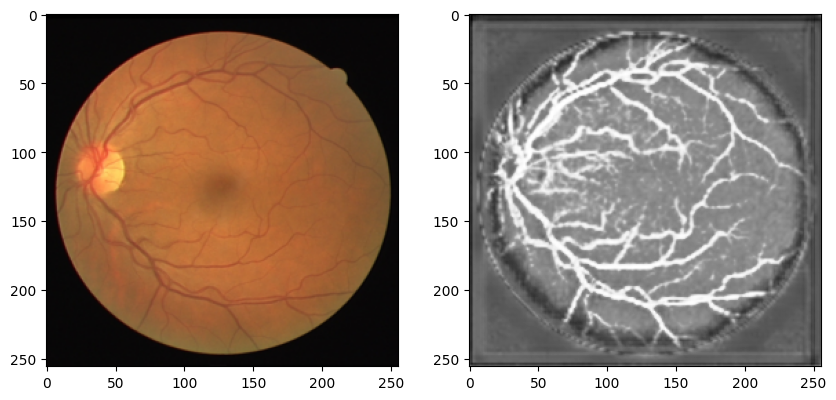

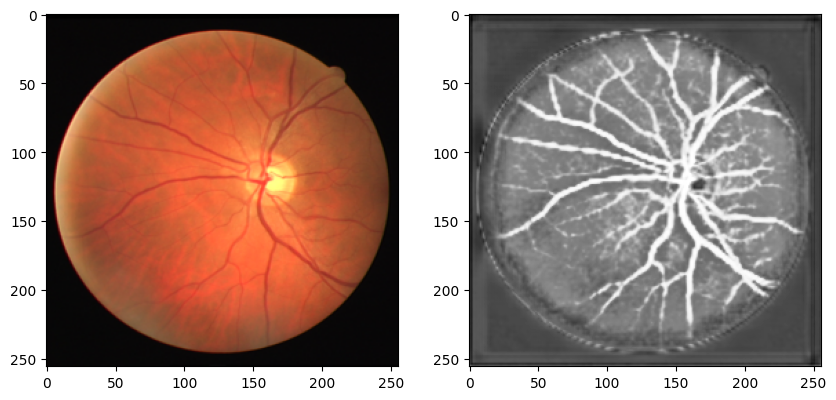

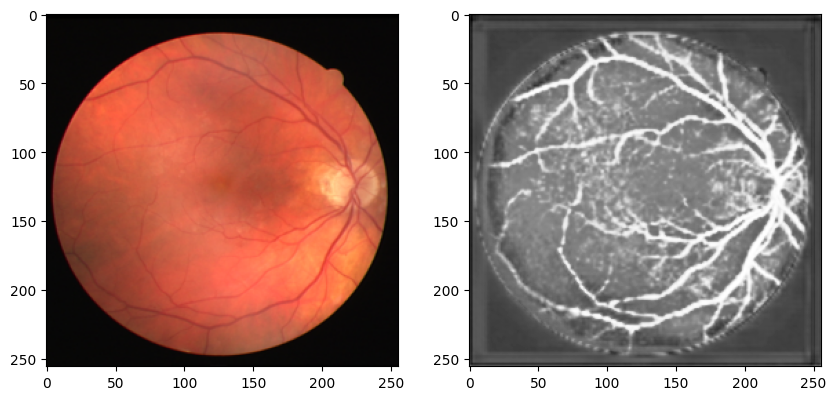

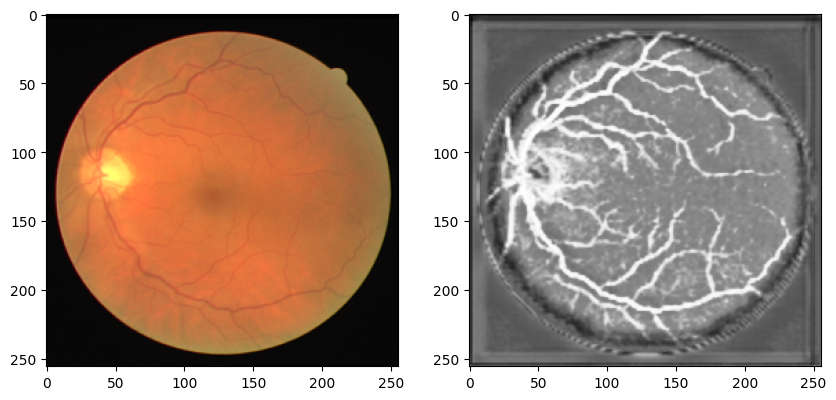

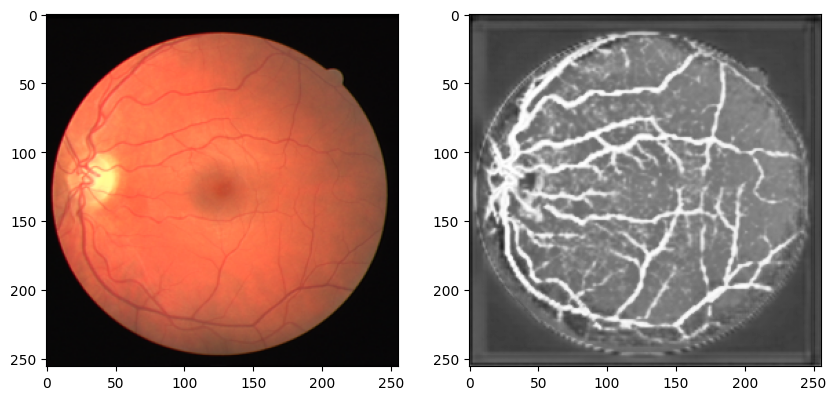

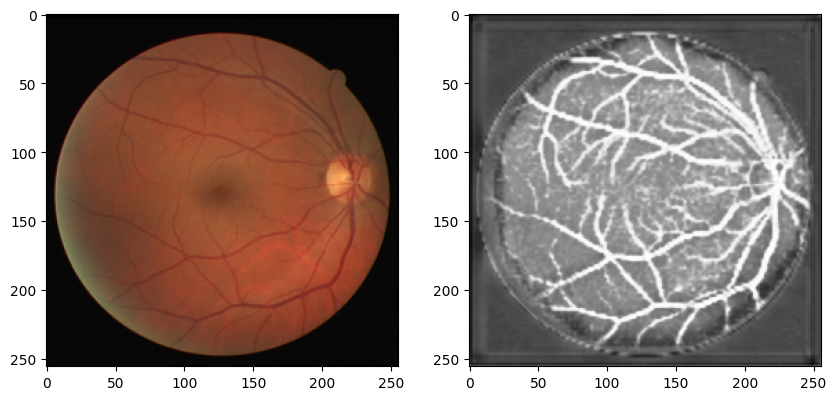

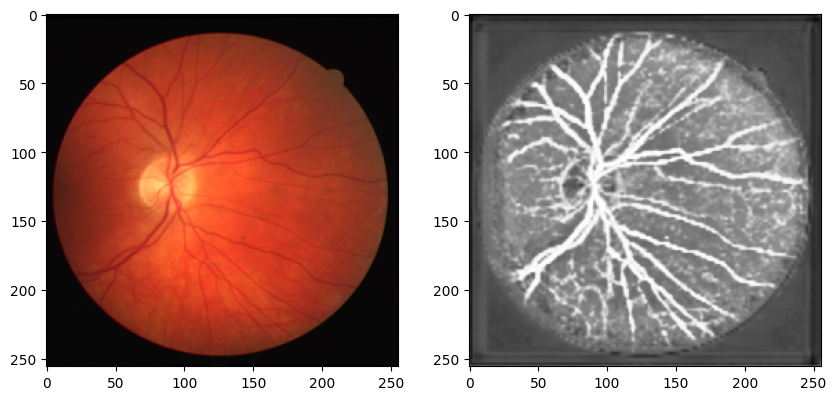

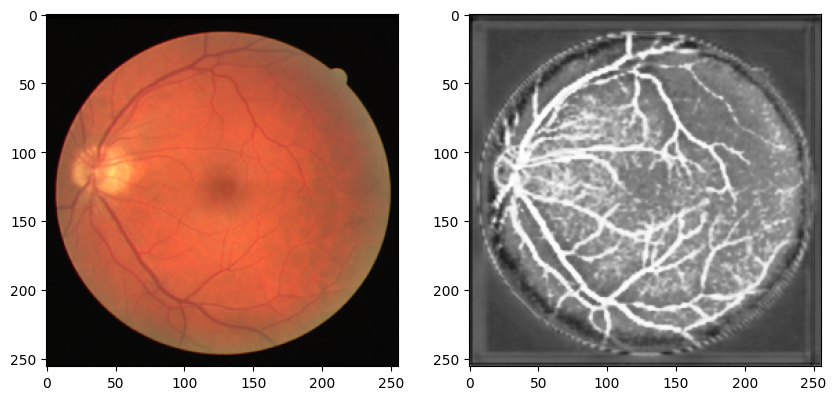

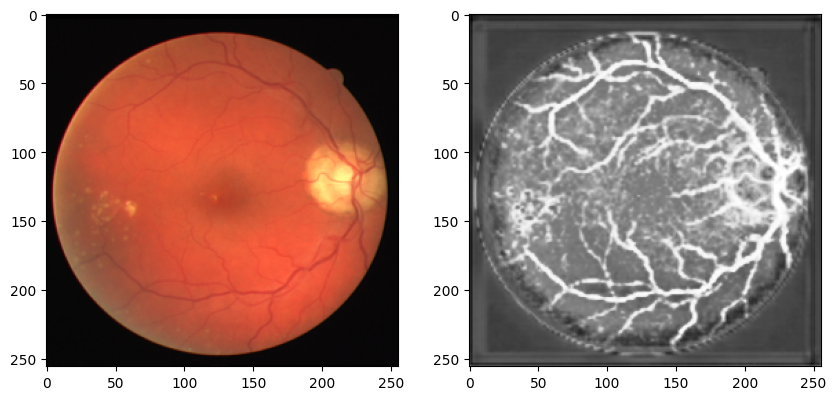

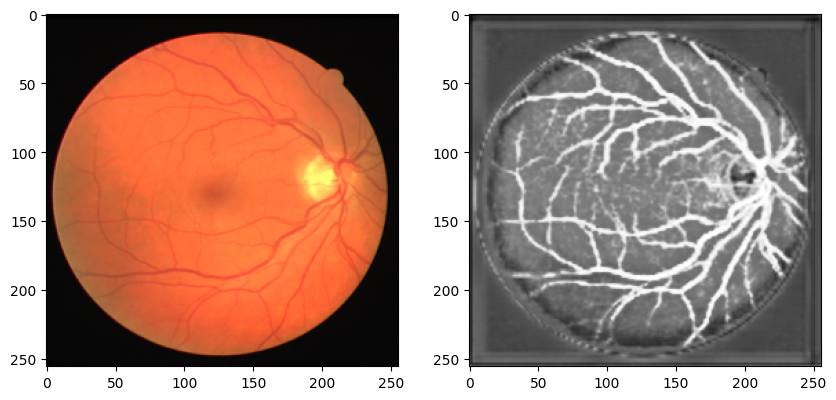

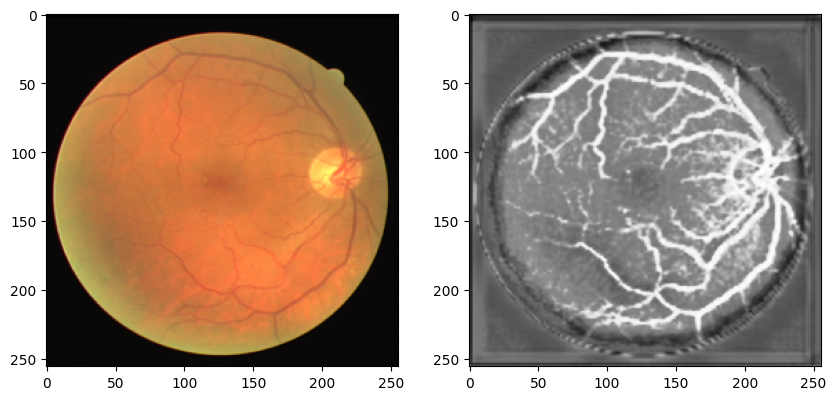

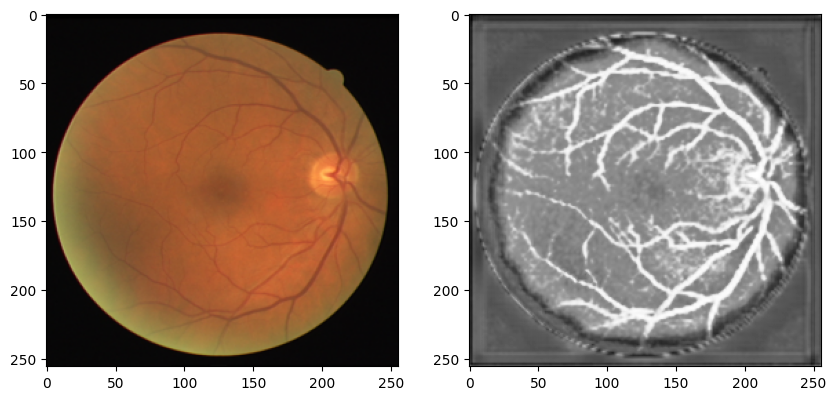

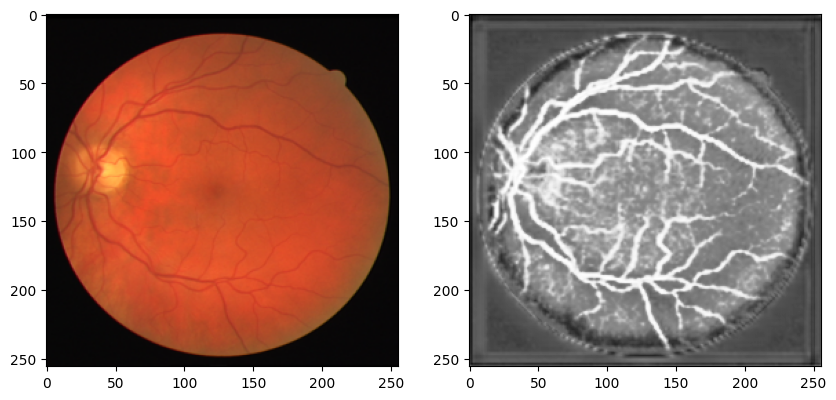

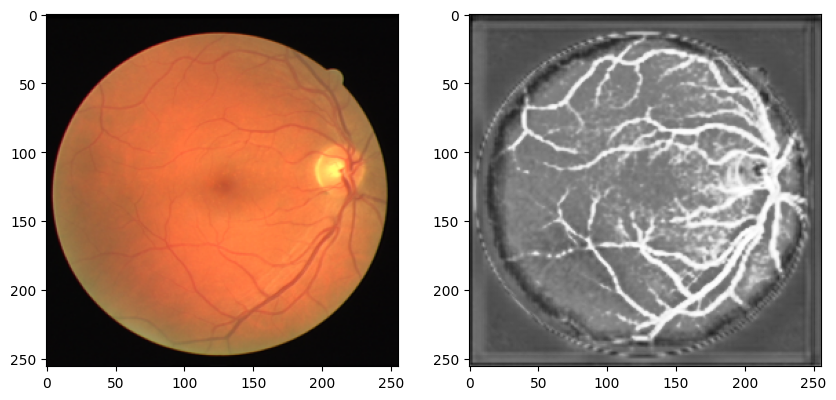

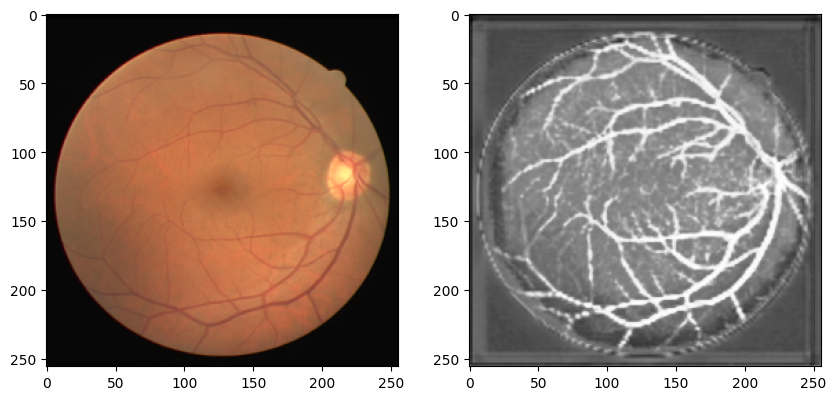

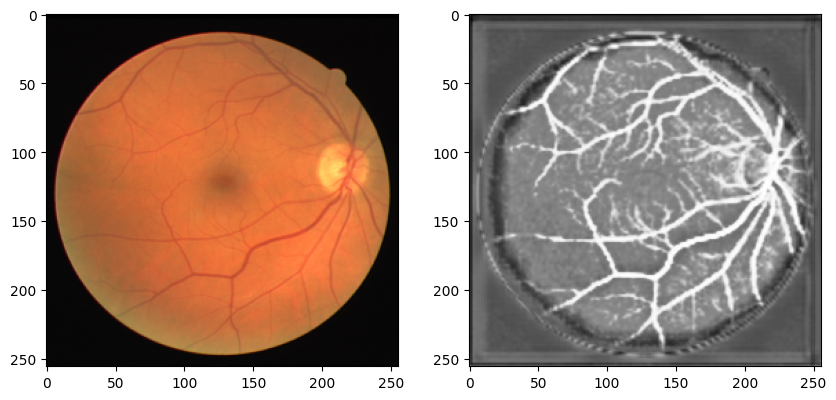

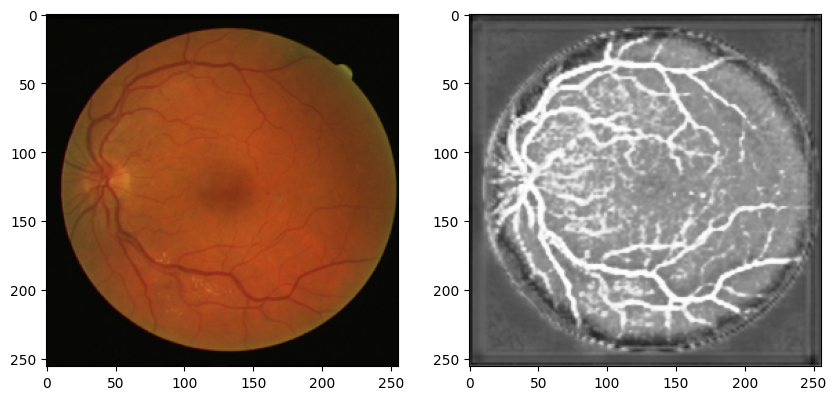

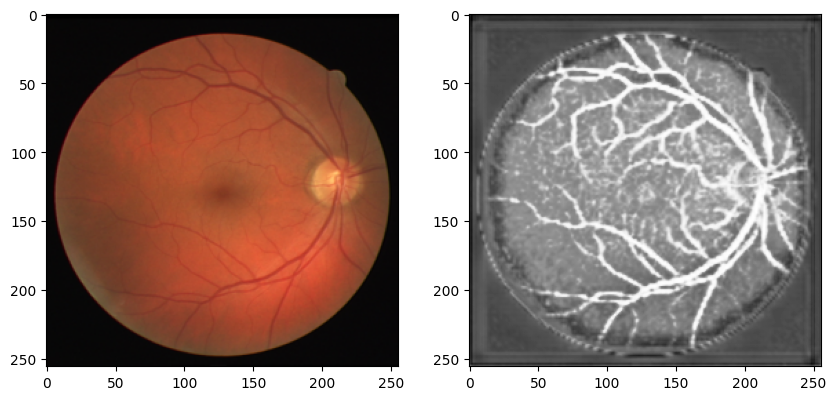

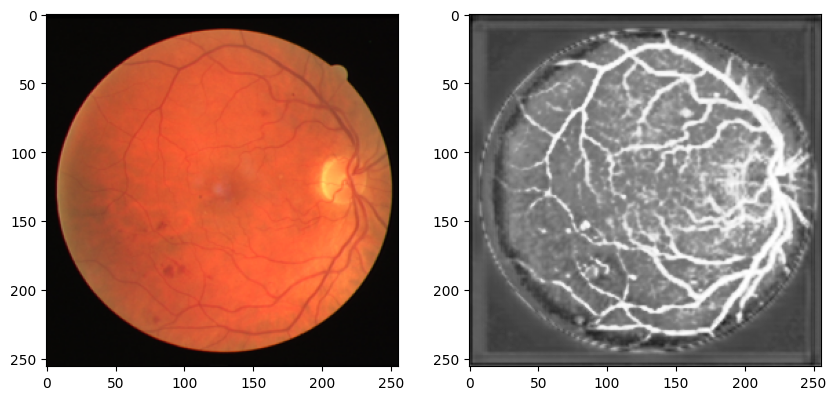

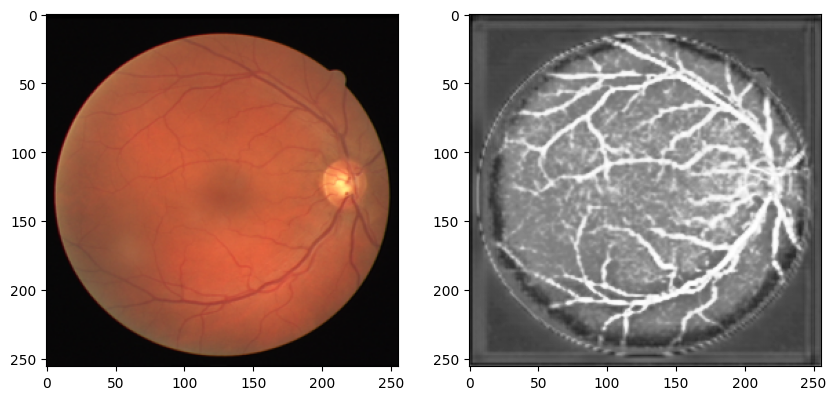

In [14]:
from glob import glob
for test_img_path in glob(test_img_dir + "/*"):
    img = transform(Image.open(test_img_path)).to(device).unsqueeze(0)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')